In [16]:
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load the dataset for recommenders

In [17]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear',
             'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [18]:
def get_p(xs, values):
    totals = [0] * len(values)
    for x in xs:
        totals[values.index(x)] += 1
    n = sum(totals)
    return [x / n for x in totals] if n > 0 else totals


def parse_column(column, interactions_df, user_features, users_df):
    df = interactions_df.loc[:, ['user_id', column]]
    df = df.groupby('user_id').aggregate(lambda x: list(x)).reset_index(drop=False)

    column_values = column_values_dict[column]
    df.loc[:, column] = df[column].apply(lambda x: get_p(x, column_values))
    ps = []

    for i in range(len(column_values)):
        ps.append("user_" + column + "_" + column_values[i])
        df.loc[:, ps[i]] = df[column].apply(lambda x: x[i])
        user_features.append(ps[i])
    users_df = pd.merge(users_df, df.loc[:, ['user_id'] + ps], on=["user_id"])

    return users_df


def prepare_users_df(interactions_df):
    ########################
    # Write your code here #
    ########################
    users_df = interactions_df.loc[:, ["user_id"]]
    users_df = users_df.groupby("user_id").first().reset_index(drop=False)
    user_features = []
    for column in base_item_features:
        users_df = parse_column(column, interactions_df, user_features, users_df)
    return users_df, user_features


users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_term_WinterVacation', 'user_term_Easter', 'user_term_OffSeason', 'user_term_HighSeason', 'user_term_LowSeason', 'user_term_MayLongWeekend', 'user_term_NewYear', 'user_term_Christmas', 'user_length_of_stay_bucket_[0-1]', 'user_length_of_stay_bucket_[2-3]', 'user_length_of_stay_bucket_[4-7]', 'user_length_of_stay_bucket_[8-inf]', 'user_rate_plan_Standard', 'user_rate_plan_Nonref', 'user_room_segment_[0-160]', 'user_room_segment_[160-260]', 'user_room_segment_[260-360]', 'user_room_segment_[360-500]', 'user_room_segment_[500-900]', 'user_n_people_bucket_[1-1]', 'user_n_people_bucket_[2-2]', 'user_n_people_bucket_[3-4]', 'user_n_people_bucket_[5-inf]', 'user_weekend_stay_True', 'user_weekend_stay_False']


,user_id,user_term_WinterVacation,user_term_Easter,user_term_OffSeason,user_term_HighSeason,user_term_LowSeason,user_term_MayLongWeekend,user_term_NewYear,user_term_Christmas,user_length_of_stay_bucket_[0-1],user_length_of_stay_bucket_[2-3],user_length_of_stay_bucket_[4-7],user_length_of_stay_bucket_[8-inf],user_rate_plan_Standard,user_rate_plan_Nonref,user_room_segment_[0-160],user_room_segment_[160-260],user_room_segment_[260-360],user_room_segment_[360-500],user_room_segment_[500-900],user_n_people_bucket_[1-1],user_n_people_bucket_[2-2],user_n_people_bucket_[3-4],user_n_people_bucket_[5-inf],user_weekend_stay_True,user_weekend_stay_False
0,1,0.090909,0.0,0.681818,0.090909,0.136364,0.000000,0.000000,0.0,0.000000,0.590909,0.409091,0.000000,0.500000,0.500000,0.000000,0.863636,0.136364,0.0,0.0,0.000000,0.727273,0.181818,0.090909,0.681818,0.318182
40,50,0.043478,0.0,0.434783,0.304348,0.217391,0.000000,0.000000,0.0,0.000000,0.913043,0.086957,0.000000,0.260870,0.739130,0.000000,0.565217,0.434783,0.0,0.0,0.000000,0.173913,0.521739,0.304348,0.782609,0.217391
84,96,0.090909,0.0,0.681818,0.136364,0.045455,0.045455,0.000000,0.0,0.272727,0.636364,0.045455,0.045455,0.272727,0.727273,0.045455,0.863636,0.090909,0.0,0.0,0.045455,0.272727,0.590909,0.090909,0.727273,0.272727
102,115,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.000000,0.500000,0.500000,0.0,0.0,0.500000,0.000000,0.000000,0.500000,0.000000,1.000000
371,706,0.095238,0.0,0.511905,0.190476,0.142857,0.047619,0.011905,0.0,0.297619,0.380952,0.238095,0.083333,0.976190,0.023810,0.035714,0.857143,0.107143,0.0,0.0,0.130952,0.154762,0.583333,0.130952,0.559524,0.440476
1383,1736,0.034483,0.0,0.482759,0.206897,0.275862,0.000000,0.000000,0.0,0.241379,0.551724,0.206897,0.000000,0.172414,0.827586,0.000000,0.931034,0.068966,0.0,0.0,0.379310,0.413793,0.206897,0.000000,0.413793,0.586207
7301,7779,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.250000,0.500000,0.250000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.750000,0.250000,0.750000,0.250000


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [19]:
def prepare_items_df(interactions_df):
    ########################
    # Write your code here #
    ########################
    item_features = ["item_id"] + base_item_features
    interactions_df = interactions_df.copy().reset_index()
    df = interactions_df.loc[:, item_features].drop_duplicates()
    one_hot_encoded = pd.get_dummies(df.loc[:, base_item_features])
    df = df.drop(base_item_features, axis=1)
    return df.join(one_hot_encoded), list(one_hot_encoded.columns)


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas', 'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]', 'rate_plan_Standard', 'rate_plan_Nonref', 'room_segment_[0-160]', 'room_segment_[160-260]', 'room_segment_[260-360]', 'room_segment_[360-500]', 'room_segment_[500-900]', 'n_people_bucket_[1-1]', 'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]', 'n_people_bucket_[5-inf]', 'weekend_stay_True', 'weekend_stay_False']


,item_id,term_WinterVacation,term_Easter,term_OffSeason,term_HighSeason,term_LowSeason,term_MayLongWeekend,term_NewYear,term_Christmas,length_of_stay_bucket_[0-1],length_of_stay_bucket_[2-3],length_of_stay_bucket_[4-7],length_of_stay_bucket_[8-inf],rate_plan_Standard,rate_plan_Nonref,room_segment_[0-160],room_segment_[160-260],room_segment_[260-360],room_segment_[360-500],room_segment_[500-900],n_people_bucket_[1-1],n_people_bucket_[2-2],n_people_bucket_[3-4],n_people_bucket_[5-inf],weekend_stay_True,weekend_stay_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [20]:
from recommenders.recommender import Recommender


class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """

    def __init__(
            self,
            seed=6789,
            n_neg_per_pos=1,
            drop_out=0.9,
            lr=0.001,
            epochs=10,
            neurons=32,
            batch_size=10
    ):
        """
        Initialize recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = n_neg_per_pos

        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None

        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)

        # You can add more arguments if needed
        ########################
        # Write your code here #
        ########################

        self.drop_out = drop_out
        self.neurons = neurons
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """

        interactions_df = interactions_df.copy()

        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)

        users_df, user_features = prepare_users_df(interactions_df)

        self.users_df = users_df
        self.user_features = user_features

        items_df, item_features = prepare_items_df(interactions_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]

        self.interactions_df = interactions_df.copy()
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1

        # Get the user-item interaction matrix (mapping to int is necessary because of how iterrows works)
        r = np.zeros(shape=(n_users, n_items))
        for idx, interaction in interactions_df.iterrows():
            r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        self.r = r

        interactions_df = interactions_df.loc[:, ['user_id', 'item_id']]

        interactions_df.loc[:, 'interacted'] = 1

        # Generate negative interactions
        ########################
        # Write your code here #
        ########################

        negative_interactions = []

        i = 0
        while i < self.n_neg_per_pos * len(interactions_df):
            size = 1000
            user_ids, item_ids = self.rng.choice(np.arange(n_users), size=size),  self.rng.choice(np.arange(n_items), size=size)
            j = 0
            while j < size and i < self.n_neg_per_pos * len(interactions_df):
                if r[user_ids[j]][item_ids[j]] == 0:
                    negative_interactions.append([user_ids[j], item_ids[j], 0])
                    i += 1
                j += 1

        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])

        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)

        interactions_df = pd.merge(interactions_df, users_df, on=['user_id'])
        interactions_df = pd.merge(interactions_df, items_df, on=['item_id'])

        # Initialize the neural network model

        ########################
        # Write your code here #
        ########################

        x = interactions_df.loc[:, user_features + item_features].values
        y = interactions_df['interacted'].values

        self.model = nn.Sequential(
            nn.Linear(len(x[0]), self.neurons),
            nn.ReLU(),
            nn.Dropout(self.drop_out),
            nn.Sigmoid(),
            nn.Dropout(self.drop_out),
            nn.Linear(self.neurons, 1)
        )
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Train the model using an optimizer

        ########################
        # Write your code here #
        ########################

        for epoch in range(self.epochs):
            for b in range((y.shape[0] - 1) // self.batch_size + 1):
                start = b * self.batch_size
                end = start + self.batch_size

                X_train = torch.tensor(x[start:end].astype(np.float32))
                Y_train = torch.tensor(y[start:end].astype(np.float32)).reshape(-1, 1)

                Y_predict = self.model(X_train)

                loss = self.loss(Y_predict, Y_train)
                loss.backward()

                self.optimizer.step()
                self.optimizer.zero_grad()

    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """

        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]

        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)

        users_df = users_df.loc[:, 'user_id']
        users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)

        items_df, item_features = prepare_items_df(items_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]

        # Score the items

        for ix, user in users_df.iterrows():

            # Calculate the score for the user and every item in items_df
            ########################
            # Write your code here #
            ########################
            cart = users_df.loc[users_df['user_id'] == user['user_id'], self.user_features].merge(
                items_df[item_features], how='cross')

            self.model.eval()
            scores = self.model(torch.tensor(cart.loc[:, user_features + item_features].values.astype(np.float32)))
            scores = scores.detach().numpy()[:, 0]

            item_ids = np.argsort(-scores)[:n_recommendations]

            recommendations = []
            for item_id in item_ids:
                recommendations.append(
                    {
                        'user_id': user['user_id'],
                        'item_id': item_id,
                        'score': scores[item_id]
                    }
                )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

# Quick test of the recommender

In [21]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

In [22]:
# Fit method
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

In [23]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1.0,575,0.223296,WinterVacation,[4-7],Nonref,[160-260],[5-inf],False
1,1.0,218,0.223296,HighSeason,[2-3],Nonref,[160-260],[2-2],True
2,1.0,594,0.223296,WinterVacation,[0-1],Nonref,[160-260],[5-inf],False
3,1.0,262,0.223296,HighSeason,[2-3],Nonref,[160-260],[5-inf],False
4,1.0,565,0.223296,WinterVacation,[2-3],Nonref,[160-260],[5-inf],False
5,1.0,211,0.223296,HighSeason,[4-7],Nonref,[160-260],[5-inf],False
6,1.0,296,0.223296,LowSeason,[2-3],Nonref,[160-260],[5-inf],False
7,1.0,344,0.223296,HighSeason,[0-1],Nonref,[160-260],[5-inf],True
8,1.0,353,0.223296,HighSeason,[0-1],Nonref,[160-260],[5-inf],False
9,1.0,167,0.223296,OffSeason,[8-inf],Nonref,[160-260],[5-inf],False


# Tuning method

In [24]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [25]:
from hyperopt import hp, fmin, tpe, Trials
import traceback


def tune_recommender(recommender_class, interactions_df, items_df,
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest,
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1

    if not succeded:
        return None

    # Validate

    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results,
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5',
                                    'NDCG@10'])

    display(HTML(results.to_html()))

    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [26]:
param_space = {
    ########################
    # Write your code here #
    ########################
    'n_neg_per_pos': hp.choice('n_neg_per_pos', [1, 5, 10, 20]),
    'drop_out': hp.uniform('drop_out', 0.0, 0.9),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'epochs': hp.choice('epochs', [10, 100, 500]),
    'neurons': hp.choice('neurons', [32, 64, 128, 256]),
    'batch_size': hp.choice('batch_size', [50, 100, 200, 500]),
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

100%|██████████| 10/10 [24:32<00:00, 147.24s/trial, best loss: -0.23529411764705882]


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.039036,0.098439,0.130686,0.241684,0.039036,0.074737,0.088015,0.123609


Best parameters:
{'batch_size': 3, 'drop_out': 0.3162509666065092, 'epochs': 2, 'lr': 0.00013554246389291255, 'n_neg_per_pos': 1, 'neurons': 3}


# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

In [28]:
nn_recommender = NNRecommender(n_neg_per_pos=1, batch_size=500, drop_out=0.3162509666065092, epochs=500, lr=0.00013554246389291255, neurons=256)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.054311,0.128649,0.18907,0.247794,0.054311,0.096547,0.121929,0.140516


In [64]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results,
    columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044128,0.118805,0.161236,0.221996,0.044128,0.086755,0.104479,0.124112


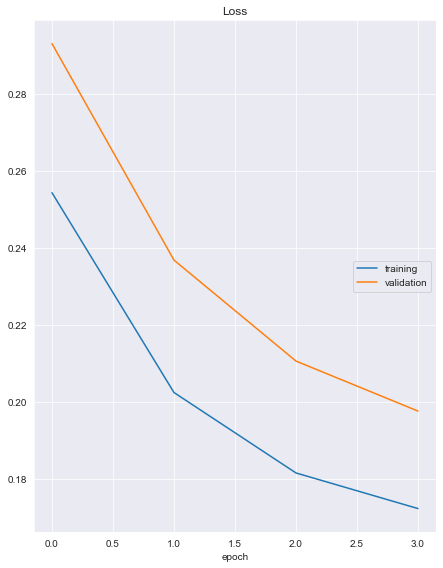

Loss
	training         	 (min:    0.172, max:    0.254, cur:    0.172)
	validation       	 (min:    0.198, max:    0.293, cur:    0.198)


In [ ]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=200, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results,
    columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [ ]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

In [27]:
###########################
# Write your summary here #
###########################
# I created a very simple Neural Network, the recommender could be improved with more sophisticated Neural Network architectures. I also tried to use `prepare_users_df` and `prepare_items_df` from the project 1, but the results were poor. I reckon that better data preparation would make the results better.